# XGBM

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [66]:
train = pd.read_csv('D:\EXCELR\Assignments\XGBM & LGBM\Titanic_train.csv')
test = pd.read_csv('D:\EXCELR\Assignments\XGBM & LGBM\Titanic_test.csv')
submission = pd.read_csv('D:/EXCELR/Assignments/XGBM & LGBM/gender_submission.csv')

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [67]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 891
Number of columns in train data: 12
Number of values in train data: 9826
Number missing values in train data: 866


In [68]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64


In [69]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [70]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [71]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values  in test data: {sum(test.isna().sum())}')

Number of rows in test data: 418
Number of columns in test data: 11
Number of values in train data: 4184
No of rows with missing values  in test data: 414


In [72]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))


Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64


In [73]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.00,418.00,332.00,418.00,418.00,417.00
mean,1100.50,2.27,30.27,0.45,0.39,35.63
std,120.81,0.84,14.18,0.90,0.98,55.91
min,892.00,1.00,0.17,0.00,0.00,0.00
25%,996.25,1.00,21.00,0.00,0.00,7.90
50%,1100.50,3.00,27.00,0.00,0.00,14.45
75%,1204.75,3.00,39.00,1.00,0.00,31.50
max,1309.00,3.00,76.00,8.00,9.00,512.33


In [74]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [75]:
train.drop(["PassengerId"] , axis = 1 , inplace = True)
test.drop(["PassengerId"] , axis = 1 , inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12 

In [76]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
Fare,891.000000,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.000000,0.523008,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Pclass,891.000000,2.308642,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Parch,891.000000,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000
Survived,891.000000,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000


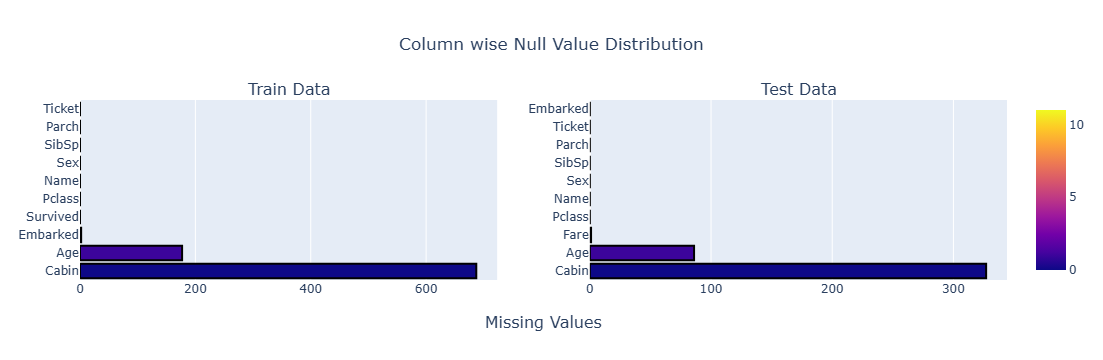

In [77]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

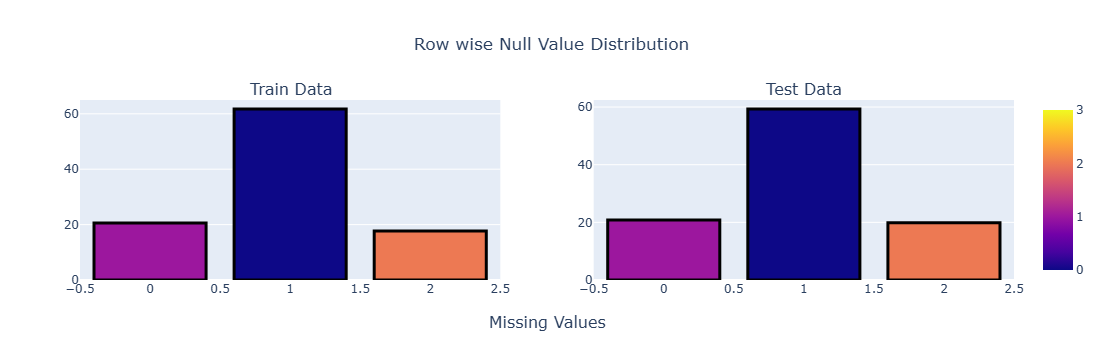

In [78]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

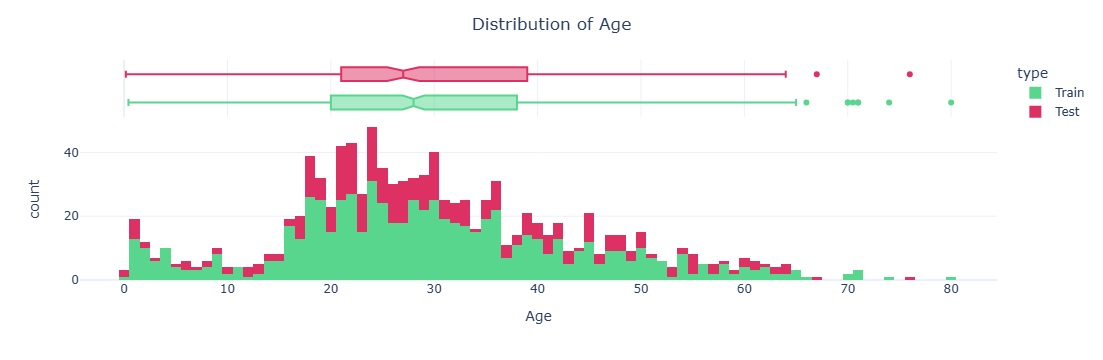

In [79]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

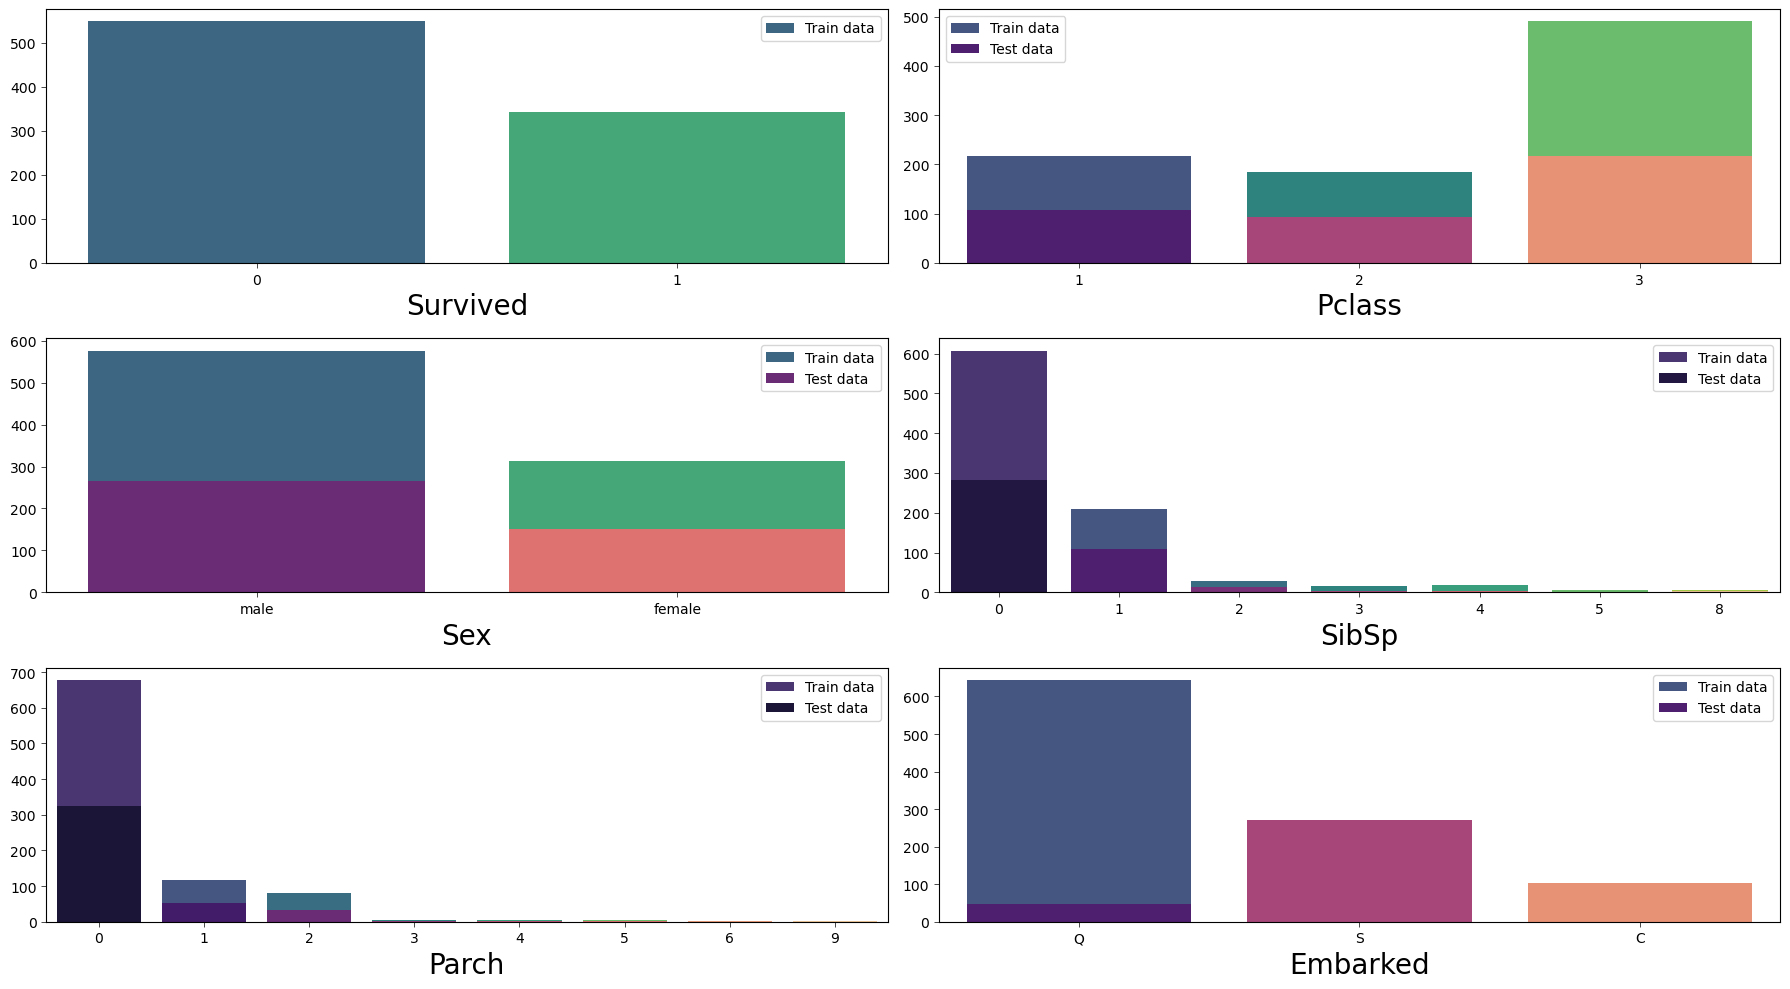

In [80]:
RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

train.head()
df = pd.concat([train, test, submission], axis=0) # Concatenate full DataFrames
df.head(5)
TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET] # Recalculate FEATURES after concatenation
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = int(np.ceil(len(cat_features) / ncols)) 

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    
    # Handle the case where there's only one plot
    if nrows == 1 and ncols == 1:
        axes = [axes] 
    else:
        axes = axes.flatten()  

    for i, col in enumerate(cat_features):
        if i < len(axes):  # Make sure we don't go out of bounds
            if col in train.columns:
                sns.countplot(data=train, x=col, ax=axes[i], palette="viridis", label='Train data')
            if col in test.columns: 
                sns.countplot(data=test, x=col, ax=axes[i], palette="magma", label='Test data')
            
            axes[i].legend()
            axes[i].set_ylabel('')
            axes[i].set_xlabel(col, fontsize=20)
            axes[i].tick_params(labelsize=10, width=0.5)
            axes[i].xaxis.offsetText.set_fontsize(4)
            axes[i].yaxis.offsetText.set_fontsize(4)

    # Remove any unused subplots 
    if len(cat_features) < nrows * ncols:
        for i in range(len(cat_features), nrows * ncols):
            fig.delaxes(axes[i])

    plt.tight_layout() 
    plt.show()

In [81]:
TARGET = 'Transported' 

# Check if 'TARGET' column exists in the DataFrame
if TARGET in df.columns:
    target_df = pd.DataFrame(df[TARGET].value_counts()).reset_index()
    target_df.columns = [TARGET, 'count']

    fig = px.bar(data_frame =target_df, 
                 x = TARGET,
                 y = 'count'
                )

    print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
    print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
    fig.show()
   

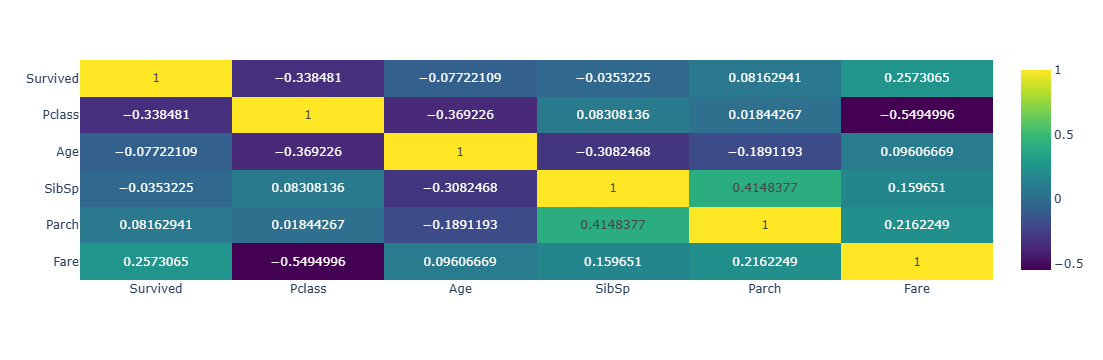

In [82]:
fig = px.imshow(train.select_dtypes(include=['number']).corr(), 
                 text_auto=True, 
                 aspect="auto", 
                 color_continuous_scale="viridis")
fig.show()

In [83]:

imputer_cols = ["Age"]
imputer = SimpleImputer(strategy=STRATEGY )
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])


train["Age"].fillna('Z', inplace=True)
test["Age"].fillna('Z', inplace=True)

In [84]:
label_cols = [ "Sex", "Embarked"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(train,test ,label_cols)

In [85]:
TARGET = 'Survived' 
train =  pd.concat([train, submission], axis=0)
test = pd.concat([test, submission], axis=0)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

In [86]:
label_cols = ["Name", "Sex","Cabin", "Embarked","Ticket"]
def label_encoder(train,test,columns):
    for col in columns:
        # Fit LabelEncoder on the combined data to ensure consistent encoding
        le = LabelEncoder()
        le.fit(pd.concat([train[col], test[col]]).astype(str))
        
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))
    return train, test

train ,test = label_encoder(train,test ,label_cols)

In [87]:
lgb_params = {
    'objective' : 'binary',
    'n_estimators' :50,
    'learning_rate' : 0.08
}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES]) 
    lgb_predictions += test_preds/FOLDS
print("")
print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
[LightGBM] [Info] Number of positive: 395, number of negative: 652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1047, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377268 -> initscore=-0.501159
[LightGBM] [Info] Start training from score -0.501159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

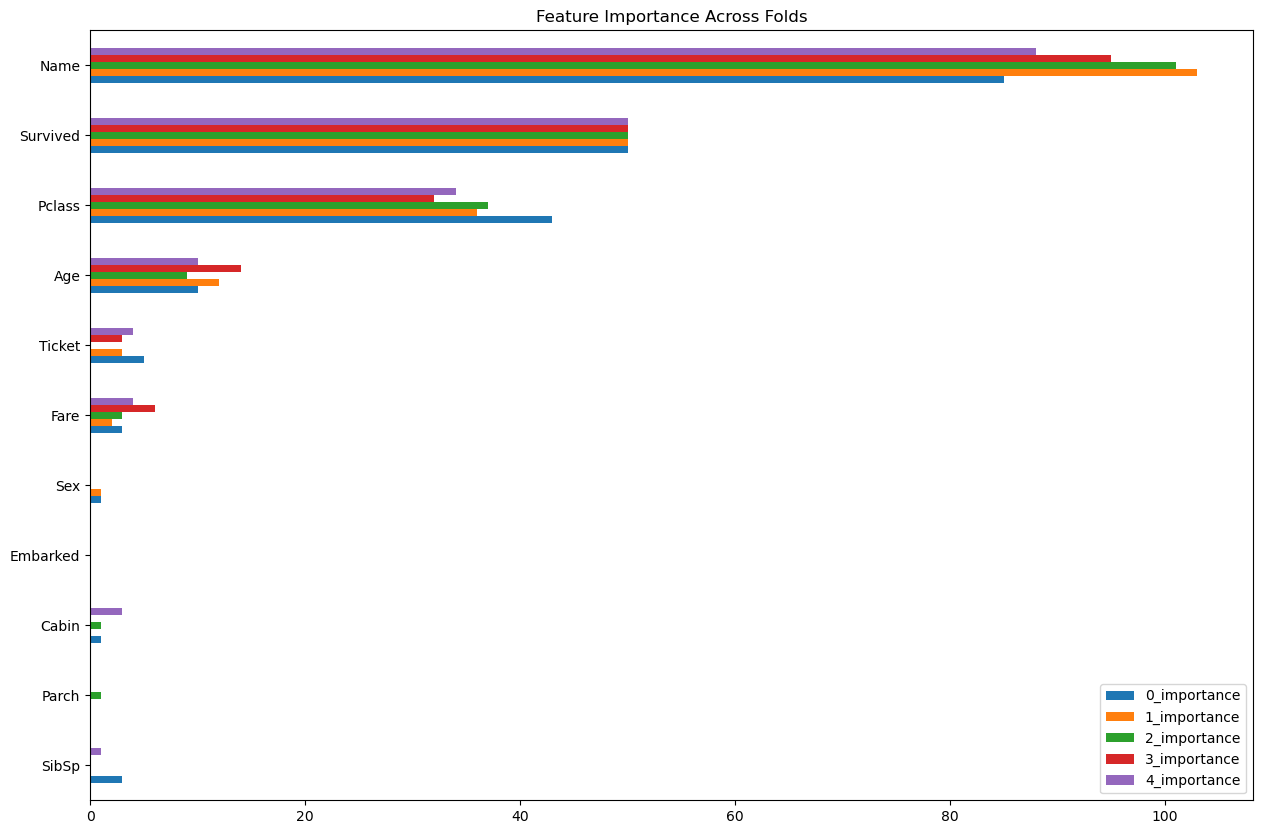

In [88]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

In [90]:
# Convert predictions to boolean and save submission
submission[TARGET] = (lgb_predictions[:len(submission)] > 0.5).astype("bool")  # Select only the predictions for the test set
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Survived
0,892,False
1,893,False
2,894,False
3,895,False
4,896,False


# LGBM

In [91]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Titanic dataset
data = pd.read_csv("D:\EXCELR\Assignments\XGBM & LGBM\Titanic_train.csv")
data.head()

# Data preprocessing
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data = pd.get_dummies(data, columns=['Embarked', 'Pclass'], drop_first=True)

# Separate independent variables and target variable
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)

# Set hyperparameters
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics=['error'],
    early_stopping_rounds=10,
    stratified=True,
    seed=42
)

best_iteration = cv_results['test-error-mean'].idxmin()
best_error = cv_results.loc[best_iteration, 'test-error-mean']

print(f"Best error rate: {best_error:.4f} (iteration: {best_iteration+1})")

dtest = xgb.DMatrix(X_test)

best_model = xgb.train(params, dtrain, num_boost_round=best_iteration+1)

predictions = best_model.predict(dtest)
predictions = [round(value) for value in predictions]

accuracy = accuracy_score(y_test, predictions)
print("Test accuracy:", accuracy)

Best error rate: 0.1728 (iteration: 9)
Test accuracy: 0.8156424581005587
